# Assignment 1 - 15-puzzle
Find solution to 15-puzzle for any starting permutation of tiles, where empty tile is on bottom right corner.
## Description of 15-puzzle
15-puzzle is a game played on 4x4 board. There are 15 blocks numbered 1 to 15 placed on the board. It leaves one tile empty.
`Move` consists of moving any block to the empty space.
We say that board is `solved` when tiles numbered 1 to 15 are placed in increasing order and last tile is empty.
In the 15-puzzle, we get as input starting configuration of tiles and position of empty tile.
`Goal` is to find sequence of moves that make the board solved.

## Analysis of solvability
Let's define $\sigma$ as parity of number of inversions.
Inversion in permutation $\pi$ is such a pair $(a,b)$, $a < b$, that $\pi(a)$ > $\pi(b)$
Define $T$ as parity of distance to the bottom. So $T = (3 - row) % 2$
Then we can define $L$ = $\sigma + T$ as invariant of our game.
### Proof:
- If move doesn't change the row of the empty tile then $\Delta T = 0$ and $\Delta \sigma = 0$, so $L' = L$
- If row is changed then $\Delta T = 1$. Let's consider $\Delta \sigma$. By moving block $X$ up or down, we change permutation $... X a_1 a_2 a_3 ...$ to $... a_1 a_2 a_3 X ...$
If only k numbers of {a_1, a_2, a_3} are bigger than $X$, that means that number of inversions generated by X before move was $3-k$ and after the move it is $k$. So difference in number of inversions is equal to $2k-3$ which is odd number. That's why $\Delta \sigma$ = 1 and $L' = T + \Delta T +  \sigma + \Delta \sigma = L + 1 + 1 = L$

It is easy to see that invariant of solved state is equal to 0.

In [1]:
# all imports
from __future__ import annotations
import os
from typing import Iterator, Callable, Optional
import heapq
import time
import json
from collections import defaultdict
import random

from dataclasses import dataclass, field

# Game State
Game state is a permutation and an empty tile. It will be represented as a `list` of 16 elements.
Empty tile will be represented as 16. To make moving faster, position of 16 will be stored.

In [2]:
def coord_to_int(row: int, col: int):
    return row*4 + col

def int_to_coord(i: int) -> tuple[int, int]:
    return i//4, i%4

def get_empty(_board:tuple[int]) -> tuple[int, int]:
    for i, tile in enumerate(_board):
        if tile == 16:
            return i
    raise RuntimeError()

class Board:
    def __init__(self, _board: tuple[int, ...], empty: int = None):
        self.board = _board
        self.empty = empty if empty is not None else get_empty(_board)

    def get_moved(self, drow: int, dcol: int) -> Board:
        goal = self.empty + drow*4 + dcol
        new_board = [*self.board]
        new_board[self.empty], new_board[goal] = new_board[goal], new_board[self.empty]
        return Board(tuple(new_board), goal)

    def get(self, row: int, col: int):
        return self.board[coord_to_int(row, col)]

    def can_move(self, drow: int, dcol: int) -> bool:
        return 0 <= self.empty//4 + drow <= 3 and 0 <= self.empty % 4 + dcol <= 3


# Solvability
Let's first implement a function that will check if board is solvable in the first place.
We can implement it with divide and conquer, but there is no need if we are going to use this only once.

In [3]:


def inverts(_board: Board) -> int:
    amount = 0
    for i in range(16):
        for j in range(i+1, 16):
            if _board.board[i] != 16 and _board.board[j] != 16:
                amount += _board.board[i] > _board.board[j]
    return amount

def is_solvable(_board: Board) -> int:
    sigma = inverts(_board)
    T = (3 - (_board.empty // 4))
    L = (sigma + T) % 2
    return L == 0

In [4]:
# solvable states
assert is_solvable(Board((1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16))) # solved
assert is_solvable(Board((1,2,3,4,5,6,7,8,9,10,11,16,13,14,15,12))) # move up from solved
assert is_solvable(Board((1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,15))) # move left from solved

# unsolvable state
assert not is_solvable(Board((1,2,3,4,5,6,7,8,9,10,11,12,13,15,14,16))) # swap 14 and 15

# Neighboring
We are going to consider following neighbourings:
- Swap $0$ tile on row $(x,y)$ with any tile from set ${ (x+1, y), (x-1, y), (x, y-1), (x, y+1) }$
- When considering board game, people usually slide up to 3 tiles in a row or column at once. Every possible state done by such move will be counted to this neighbouring

In [5]:
moves = ((0,1), (0,-1), (-1,0), (1,0))
directions_names = dict(zip(moves, "RLUD"))
name_to_direction = dict(zip("RLUD", moves))

def one_move_neighbouring(_board: Board) -> Iterator[tuple[Board, str]]:
    for direction in moves:
        if _board.can_move(*direction):
            yield _board.get_moved(*direction), directions_names[direction]

def line_move_neighbouring(_board: Board) -> Iterator[tuple[Board, str]]:
    for direction in moves:
        new_board = _board
        path = ""
        for i in range(3):
            if new_board.can_move(*direction):
                path += directions_names[direction]
                new_board = new_board.get_moved(*direction)
                yield new_board, path

# Heuristics
We are going to consider following heuristics
1. Misplaced tiles - Amount of tiles not on their position
2. Manhattan Distance - Manhattan Distance from every tile to their appropriate position
3. Manhattan Distance + Linear Conflict

In [6]:
def taxicab_distance(x1: int, y1: int, x2: int, y2: int):
    return abs(x2-x1) + abs(y2-y1)

def misplaced_tiles(_board: Board, prev_heuristics: int = -1, direction: str = None):
    if prev_heuristics == -1:
        heuristics = 16
        for i, tile in enumerate(_board.board):
            heuristics -= (tile - 1 == i)
            
    drow, dcol = name_to_direction[direction]
    
    

def taxicab_heuristics(_board: Board, prev_heuristics: int = -1, direction: str = None):
    if prev_heuristics == -1:
        heuristics = 0
        for i, tile in enumerate(_board.board):
            heuristics += taxicab_distance(*int_to_coord(i), *int_to_coord(tile-1))
        return heuristics

    drow, dcol = name_to_direction[direction]
    prev_heuristics += int(-1 in [drow, dcol])*2 - 1

    row, col = int_to_coord(_board.empty)
    from_row, from_col = row-drow, col-dcol
    tile_swapped_with_0 = _board.get(from_row, from_col)
    goal_row, goal_col = int_to_coord(tile_swapped_with_0 - 1)

    prev_heuristics -= (abs(goal_row-from_row) < abs(goal_row - row) or abs(goal_col - from_col) < abs(goal_col - col))*2-1
    return prev_heuristics


In [7]:

assert taxicab_heuristics(Board((1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16))) == 0 # solved
assert taxicab_heuristics(Board((1,2,3,4,5,6,7,8,9,10,11,16,13,14,15,12))) == 2 # move up from solved
assert taxicab_heuristics(Board((1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,15))) == 2 # move left from solved
assert taxicab_heuristics(Board((1,2,16,3,5,6,7,4,9,10,11,8,13,14,15,12))) == 8 # move up up up left

assert taxicab_heuristics(Board((1,2,3,4,5,6,7,8,9,10,11,16,13,14,15,12)), 0, "U") == 2 # move up from solved
assert taxicab_heuristics(Board((1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,15)), 0, "L") == 2 # move left from solved
assert taxicab_heuristics(Board((1,2,16,3,5,6,7,4,9,10,11,8,13,14,15,12)), 6, "L") == 8 # move up up up left
assert taxicab_heuristics(Board((1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 16, 13, 14, 15, 12)), 4, "R") == 2 # up left -> right

# A* Algorithm

In [8]:
@dataclass(order=True)
class PrioritizedItem:
    priority: int
    board: Board=field(compare=False)
    heuristics: int=field(compare=False)

    def __post_init__(self):
        self.priority += self.heuristics

def reconstruct_path(
    parent_tree: dict,
    _board: tuple[int, ...]
) -> list[str]:
    total_path = []
    while _board in parent_tree:
        _board, path = parent_tree[_board]
        total_path.append(path)
    return total_path[::-1]


def a_star(
    start: Board,
    goal: Board,
    heuristics: Callable,
    neighbouring: Callable
) -> tuple[list[str], int]:

    distances = {start.board: 0}
    pq = [PrioritizedItem(0, start, heuristics(start))]
    parent_tree = {}
    visited = 0
    while pq:
        prioritized_item = heapq.heappop(pq)
        _board = prioritized_item.board
        visited += 1
        if _board.board == goal.board:
            return reconstruct_path(parent_tree, goal.board), visited

        for neighbour, path in neighbouring(_board):
            new_neighbour_distance = distances[_board.board] + len(path)
            if new_neighbour_distance < distances.get(neighbour.board, new_neighbour_distance + 1):
                parent_tree[neighbour.board] = (_board.board, path)
                distances[neighbour.board] = new_neighbour_distance
                heapq.heappush(pq, PrioritizedItem(distances[neighbour.board], neighbour, heuristics(neighbour, prioritized_item.heuristics, path)))

# The Simplest Test

|     |     |     |     |
|-----|-----|-----|-----|
| 1   | 2   | 3   | 4   |
| 5   | 6   | 6   | 7   |
| 9   | 10  | 16  | 11  |
| 13  | 14  | 15  | 12  |

In [9]:
_goal = Board((1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16))
_start = Board((1,2,3,4,5,6,7,8,9,10,16,11,13,14,15,12))
solution_one_move, am_states_one_move = a_star(_start, _goal, taxicab_heuristics, one_move_neighbouring)
print(f"One move : Length {len(solution_one_move)}, path:", solution_one_move, f"amount states: {am_states_one_move}")

One move : Length 2, path: ['R', 'D'] amount states: 3


# Simplest Test
Simple test on instance shuffled by following sequence of moves.
moves = U U L D

|     |     |     |     |
|-----|-----|-----|-----|
| 1   | 2   | 3   | 4   |
| 5   | 6   | 11  | 7   |
| 9   | 10  | 16  | 8   |
| 13  | 14  | 15  | 12  |

In [10]:
_start = Board((1,2,3,4,5,6,11,7,9,10,16,8,13,14,15,12))
solution_one_move, am_states_one_move = a_star(_start, _goal, taxicab_heuristics, one_move_neighbouring)
print(f"One move : Length {len(solution_one_move)}, path:", solution_one_move, f"amount states: {am_states_one_move}")

One move : Length 4, path: ['U', 'R', 'D', 'D'] amount states: 7


# Simple Test
Simple test on instance shuffled by following sequence of moves.
moves = U U U L L L D D D R R U U L D
In simple words we are moving 0 in a spiral shape and the end result is

|     |     |     |     |
|-----|-----|-----|-----|
| 5   | 1   | 2   | 3   |
| 9   | 10  | 6   | 4   |
| 13  | 16  | 7   | 8   |
| 14  | 15  | 11  | 12  |

In [11]:
_start = Board((5,1,2,3,9,10,6,4,13,16,7,8,14,15,11,12))
solution_one_move, am_states_one_move = a_star(_start, _goal, taxicab_heuristics, one_move_neighbouring)
print(f"One move : Length {len(solution_one_move)}, path:", solution_one_move, f"amount states: {am_states_one_move}")

One move : Length 15, path: ['U', 'R', 'D', 'D', 'L', 'L', 'U', 'U', 'U', 'R', 'R', 'R', 'D', 'D', 'D'] amount states: 54


# Automatic Checker
We need a function to check if solution given by algorithm is correct

In [12]:
def is_path_valid(
    start: Board,
    goal: Board,
    path: list[str]
):
    for move_string in path:
        for move in move_string:
            direction = name_to_direction[move]
            if start.can_move(*direction):
                start = start.get_moved(*direction)
    return start.board == goal.board

In [13]:
assert is_path_valid(_start, _goal, solution_one_move)

# Solver
We can now connect checking if board is solvable, solving and checking if solution is correct.

In [14]:
def solve(
        start: Board,
        heuristics: Callable,
        neighbouring: Callable
) -> tuple[Optional[list[str]], Optional[int], Optional[int]]:
    if not is_solvable(start):
        return None, None, None
    goal = Board((1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16))
    time_start = time.time()
    path, visited_states = a_star(start, goal, heuristics, neighbouring)
    time_needed = time.time() - time_start

    if not is_path_valid(start, goal, path):
        raise RuntimeError(f"Wrong path found start={json.dumps(start.board)} path={json.dumps(path)}")

    return path, visited_states, time_needed

# Tester
We want to have a way to generate new boards, test heuristics and neighbouring, save data for later visualisation

In [24]:
import json
from collections import defaultdict
import random

def save_data(filename: str, data: dict):
    if not os.path.isdir("data"):
        os.mkdir("data")
    with open(f"data/{filename}.json", "w+") as file:
        file.write(json.dumps(data))

def load_data(filename: str) -> dict:
    if not os.path.isdir("data"):
        os.mkdir("data")
    with open(f"data/{filename}.json", "r+") as file:
        return json.loads(file.read())

def generate_board(_max_moves: int) -> Board:
    _board = list(range(1,17))
    if _max_moves == 0:
        random.shuffle(_board)
        return Board(tuple(_board), 15)
    _board = Board(tuple(_board), 15)

    i = 0
    previous_move = None
    while i < _max_moves:
        move = random.choice(moves)
        if _board.can_move(*move) and previous_move != move:
            i += 1
            _board = _board.get_moved(*move)
            previous_move = move
    return _board

def test(name: str, execute_time: int, heuristics: Callable, neighbouring: Callable, max_path_moves: int=0):
    path_len_to_visited_states = defaultdict(list)
    solvable = 0
    non_solvable = 0

    start_time = time.time()
    now_time = time.time()
    while now_time - start_time < execute_time:
        _board = generate_board(max_path_moves)
        path, visited_states, _ = solve(_board, heuristics, neighbouring)
        if path is None:
            non_solvable += 1
        else:
            path_len_to_visited_states[sum(map(len, path))].append(visited_states)
        solvable += 1
        now_time = time.time()
    _data = {"solvable": solvable, "non_solvable": non_solvable, "data": path_len_to_visited_states, "time_s": execute_time, "time_spent": now_time-start_time}
    save_data(name, _data)
    return _data

In [39]:
def solve_instance(instance: tuple[int, ...]):
    answer = solve(Board(instance), taxicab_heuristics, one_move_neighbouring)
    print(answer[0])
    print(f"Solution length: {len(answer[0])}, visited_states: {answer[1]}, time: {answer[2]}, states_per_second: {answer[1]/answer[2]}")

def states_per_second(data: dict):
    return data["time_spent"] / sum(map(sum, data["data"].values()))

In [47]:
solve_instance((3,11,6,10,1,9,8,15,4,5,2,7,13,14,12,16))


['U', 'U', 'L', 'U', 'L', 'L', 'D', 'R', 'D', 'L', 'U', 'R', 'D', 'R', 'U', 'L', 'D', 'R', 'D', 'R', 'U', 'U', 'U', 'L', 'D', 'R', 'D', 'L', 'U', 'R', 'U', 'L', 'L', 'D', 'D', 'R', 'D', 'R', 'U', 'U', 'L', 'D', 'R', 'D']
Solution length: 44, visited_states: 243235, time: 2.860846996307373, states_per_second: 85022.02330776677


In [48]:
solve_instance((1, 5, 7, 3, 6, 16, 8, 4, 2, 9, 10, 11, 13, 14, 15, 12))

['D', 'L', 'U', 'R', 'D', 'R', 'U', 'L', 'U', 'R', 'D', 'D', 'L', 'L', 'U', 'R', 'U', 'R', 'R', 'D', 'L', 'L', 'D', 'R', 'R', 'D']
Solution length: 26, visited_states: 17017, time: 0.18043112754821777, states_per_second: 94312.99483207207


In [42]:
solve_instance((1,2,3,4,5,6,7,8,9,10,11,16,13,14,15,12))

['D']
Solution length: 1, visited_states: 2, time: 3.4332275390625e-05, states_per_second: 58254.22222222222


In [50]:
solve_instance((11,4,12,2,5,10,3,15,14,1,6,7,16,9,8,13))

['U', 'R', 'U', 'L', 'D', 'R', 'R', 'R', 'U', 'U', 'L', 'L', 'L', 'D', 'R', 'R', 'R', 'U', 'L', 'D', 'L', 'U', 'R', 'D', 'D', 'D', 'R', 'U', 'U', 'L', 'L', 'D', 'L', 'D', 'R', 'R', 'R', 'U', 'L', 'L', 'L', 'D', 'R', 'U', 'R', 'U', 'R', 'D', 'D']
Solution length: 49, visited_states: 5104435, time: 129.1023988723755, states_per_second: 39537.878804606895


In [29]:
#test("taxicab_onemove", 1200, taxicab_heuristics, one_move_neighbouring, 60)

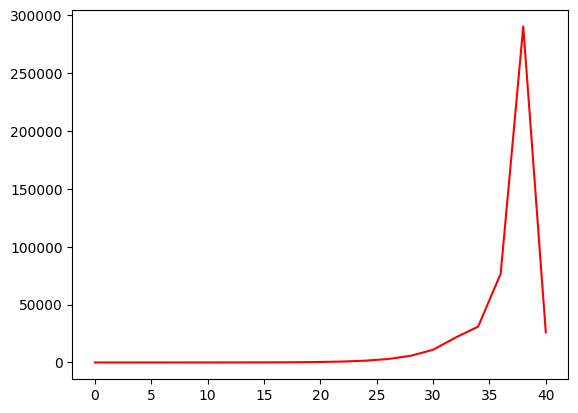

In [30]:
import matplotlib.pyplot as plt
def len_path_visited_states(data):
    xs = sorted(list(map(int, data.keys())))
    ys = list([sum(data[str(x)])/len(data[str(x)]) for x in xs])
    return xs, ys

def make_len_path_to_avg_visited_states():
    onemove = load_data("taxicab_onemove_1200_60")
    plt.plot(*len_path_visited_states(onemove['data']), label="onemove", color="red")
    plt.show()
make_len_path_to_avg_visited_states()